# **PROYECTO HUMOR** Modelo Multiclase con Modelo Preentrenado basado en BERT

**Autores:**

* Juan Camilo Acosta Rojas - 202324893
* Samuel Goncalves Vergara - 202122595
* Jefferson Hernández - 202120242
* Juan Andrés Mendez - 201815808

In [1]:
import pandas as pd
from transformers import AutoModel, BertTokenizerFast, TFBertModel, AutoTokenizer, BertTokenizer, AdamW
#from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input,Concatenate
import tensorflow as tf
#import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
from sklearn.cluster import KMeans
import joblib
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from sklearn.metrics import classification_report

%matplotlib inline

/home/estudiante/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 14:52:37.197602: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 14:52:37.239257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 14:52:37.239287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 14:52:37.240340: E

## Loading Data

In [2]:
url_graceful_dataset = 'humor_dataset.csv'
df_graceful = pd.read_csv(url_graceful_dataset)

In [3]:
df_graceful

,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3
0,1,"Mi abuelo vino a América buscando la libertad,...",Dataset_existente,1,1,1,1,3,4,3
1,2,BARRA LIBRE en mi casa hoy a partir de las 10 ...,Dataset_existente,1,1,1,1,2,3,3
2,3,Va un pollito con un cubito Maggi bajo el braz...,Dataset_existente,1,1,1,1,4,2,3
3,4,"-¿Ya fuiste al Laberinto? -No, está bueno? -Si...",Dataset_existente,1,1,1,1,2,2,3
4,5,En la calle me siento un objeto sexual\n\nMe g...,Dataset_existente,1,0,1,1,4,0,5
...,...,...,...,...,...,...,...,...,...,...
9995,9996,hr6gbo_There never was.jpg: Dos astronautas en...,Imágenes/Internet,1,1,1,1,3,1,2
9996,9997,1d16a75_yo_ctm.jpg: una pintura de una mujer c...,Imágenes/Internet,1,1,1,1,3,2,3
9997,9998,1c018zi_Pepino_ctm.jpg: una captura de pantall...,Imágenes/Internet,1,1,1,1,5,3,2
9998,9999,110wugt_gracias loco.jpg: un mensaje de texto ...,Imágenes/Internet,1,1,1,1,4,3,4


In [4]:
def set_humor_rating(h1, h2, h3):
    if pd.isna(h1):
        return 0
    else:
        return (int)((h1+h2+h3)/3)

df_graceful['humor_target'] = df_graceful.apply(
    lambda row: set_humor_rating(row['nivel_gracia_p1'], 
                                 row['nivel_gracia_p2'], 
                                 row['nivel_gracia_p3']), axis=1
)

In [5]:
df_graceful.head()

,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,humor_target
0,1,"Mi abuelo vino a América buscando la libertad,...",Dataset_existente,1,1,1,1,3,4,3,3
1,2,BARRA LIBRE en mi casa hoy a partir de las 10 ...,Dataset_existente,1,1,1,1,2,3,3,2
2,3,Va un pollito con un cubito Maggi bajo el braz...,Dataset_existente,1,1,1,1,4,2,3,3
3,4,"-¿Ya fuiste al Laberinto? -No, está bueno? -Si...",Dataset_existente,1,1,1,1,2,2,3,2
4,5,En la calle me siento un objeto sexual\n\nMe g...,Dataset_existente,1,0,1,1,4,0,5,3


### Data Preprocessing

In [6]:
def preprocess_text(text):
    # Transform URLs
    text = re.sub(r'http\S+', '<URL>', text)

    # Transform other user mentions
    text = re.sub(r'@\w+', '<USUARIO>', text)

    # Delete emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text)
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-\(|:-\*|:-\)|:P|:D|:<|:-P', '<EMOJI>', text)

    # Transform hashtags
    text = re.sub(r'#\w+', '<HASH_TAG>', text)

    #Transform Captioning Images Names
    # Reemplazar el nombre del archivo con el token <IMAGE>
    result = re.sub(r"[\w-]+\.(jpg|jpeg|png|gif):", "<IMAGE>:", text)

    return text


In [7]:
df_graceful['text'] = df_graceful['text'].apply(preprocess_text)
df_graceful.head()

,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,humor_target
0,1,"Mi abuelo vino a América buscando la libertad,...",Dataset_existente,1,1,1,1,3,4,3,3
1,2,BARRA LIBRE en mi casa hoy a partir de las 10 ...,Dataset_existente,1,1,1,1,2,3,3,2
2,3,Va un pollito con un cubito Maggi bajo el braz...,Dataset_existente,1,1,1,1,4,2,3,3
3,4,"-¿Ya fuiste al Laberinto? -No, está bueno? -Si...",Dataset_existente,1,1,1,1,2,2,3,2
4,5,En la calle me siento un objeto sexual\n\nMe g...,Dataset_existente,1,0,1,1,4,0,5,3


In [8]:
# Verificar si quedan registros con categoría 5
print(df_graceful['humor_target'].value_counts())

humor_target
2    4719
1    3202
3    1846
4     149
0      83
5       1
Name: count, dtype: int64


In [9]:
# Define el umbral mínimo de registros
min_samples = 1846

# Filtra las categorías que tienen al menos min_samples registros
valid_categories = df_graceful['humor_target'].value_counts()
valid_categories = valid_categories[valid_categories >= min_samples].index.tolist()

# Filtrar el DataFrame para incluir solo las categorías válidas
filtered_dataset = df_graceful[df_graceful['humor_target'].isin(valid_categories)]

# Selección de muestras equilibradas
balanced_dataset = (
    filtered_dataset.groupby('humor_target')
    .sample(n=min_samples, random_state=2024)
)

balanced_dataset['humor_target'] = balanced_dataset['humor_target'].apply(lambda x: x -1)

# Verificar la cantidad de datos por clase en el dataset resultante
print(balanced_dataset['humor_target'].value_counts())

humor_target
0    1846
1    1846
2    1846
Name: count, dtype: int64


### Splitting Data

In [10]:
# Divide el dataset original en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    balanced_dataset['text'],
    balanced_dataset['humor_target'],
    random_state=2024,
    test_size=0.2,  # El 20% se reserva para pruebas finales
    stratify=balanced_dataset['humor_target']
)

# Divide el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    random_state=2024,
    test_size=0.3,  # El 30% del conjunto de entrenamiento inicial será para validación
    stratify=y_train
)

## Tokenize Data

Text(0, 0.5, 'Number of texts')

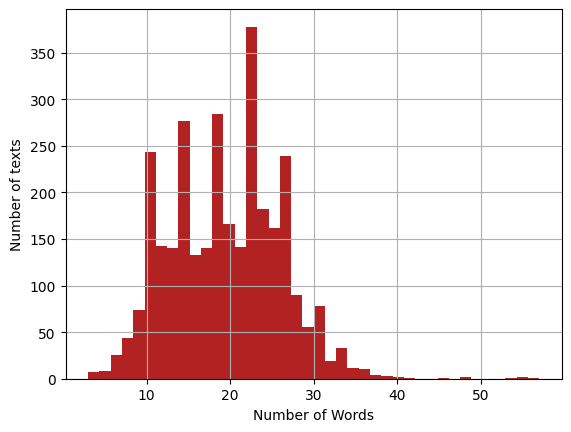

In [11]:
seq_len = [len(title.split()) for title in X_train]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [12]:
MAX_LENGHT = 25

In [13]:
tokenizer = BertTokenizerFast.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def tokenize(data_to_tokenize):
  return tokenizer.batch_encode_plus(
    data_to_tokenize.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
  )

In [14]:
tokens_train = tokenize(X_train)
tokens_val = tokenize(X_val)
tokens_test = tokenize(X_test)

/home/estudiante/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
# 1. Data Preparation
def prepare_data(tokens, labels):
    # Convert to tensors with explicit dtype
    seq = torch.tensor(tokens['input_ids'], dtype=torch.long)
    mask = torch.tensor(tokens['attention_mask'], dtype=torch.long)
    labels = torch.tensor(labels.tolist(), dtype=torch.long)
    
    print(f"Sequence shape: {seq.shape}, dtype: {seq.dtype}")
    print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
    print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")
    
    return seq, mask, labels

# Prepare datasets
train_seq, train_mask, train_y = prepare_data(tokens_train, y_train)
val_seq, val_mask, val_y = prepare_data(tokens_val, y_val)
test_seq, test_mask, test_y = prepare_data(tokens_test, y_test)



Sequence shape: torch.Size([3101, 25]), dtype: torch.int64
Mask shape: torch.Size([3101, 25]), dtype: torch.int64
Labels shape: torch.Size([3101]), dtype: torch.int64
Sequence shape: torch.Size([1329, 25]), dtype: torch.int64
Mask shape: torch.Size([1329, 25]), dtype: torch.int64
Labels shape: torch.Size([1329]), dtype: torch.int64
Sequence shape: torch.Size([1108, 25]), dtype: torch.int64
Mask shape: torch.Size([1108, 25]), dtype: torch.int64
Labels shape: torch.Size([1108]), dtype: torch.int64


In [17]:
# 2. Create DataLoaders
def create_dataloader(sequences, masks, labels, batch_size, is_training=True):
    dataset = TensorDataset(sequences, masks, labels)
    sampler = RandomSampler(dataset) if is_training else SequentialSampler(dataset)
    return DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size,
        pin_memory=True
    )

# Create dataloaders
batch_size = 32
train_dataloader = create_dataloader(train_seq, train_mask, train_y, batch_size, is_training=True)
val_dataloader = create_dataloader(val_seq, val_mask, val_y, batch_size, is_training=False)
test_dataloader = create_dataloader(test_seq, test_mask, test_y, batch_size, is_training=False)

## Build Model

In [18]:
bert_spanish = AutoModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

for param in bert_spanish.parameters():
    param.requires_grad = False

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
class BERT_model(nn.Module):
    def __init__(self, bert):
      super(BERT_model, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,3)               # dense layer 2
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

In [24]:
model = BERT_model(bert_spanish)

optimizer = AdamW(model.parameters(), lr = 1e-5)
cross_entropy  = nn.CrossEntropyLoss()
epochs = 25

/home/estudiante/venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train the Model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [52]:
# Verify batch structure
for batch in train_dataloader:
    print("Batch type:", type(batch))
    print("Batch content types:", [type(x) for x in batch])
    print("Batch content shapes:", [x.shape for x in batch])
    break

Batch type: <class 'list'>
Batch content types: [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Batch content shapes: [torch.Size([32, 25]), torch.Size([32, 25]), torch.Size([32])]


In [53]:
def train(model, train_dataloader, optimizer, cross_entropy, device):
    model.train()
    total_loss = 0
    
    # Ensure model is on correct device
    model = model.to(device)
    
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        try:
            # Unpack batch and move to device
            sent_id, mask, labels = [b.to(device) for b in batch]
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            preds = model(sent_id, mask)
            
            # Compute loss
            loss = cross_entropy(preds, labels)
            
            # Backward pass
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            optimizer.step()
            
            total_loss += loss.item()
            
        except RuntimeError as e:
            print(f"Error in batch {step}")
            print(f"Input shapes: {sent_id.shape}, {mask.shape}, {labels.shape}")
            print(f"Input devices: {sent_id.device}, {mask.device}, {labels.device}")
            print(f"Model device: {next(model.parameters()).device}")
            raise e
    
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [54]:
def evaluate(model, val_dataloader, cross_entropy, device):
    print("\nEvaluating...")
    model.eval()
    total_loss = 0
    
    # Ensure model is on correct device
    model = model.to(device)
    
    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
            
        try:
            # Unpack batch and move to device
            sent_id, mask, labels = [b.to(device) for b in batch]
            
            # Forward pass with no gradient computation
            with torch.no_grad():
                preds = model(sent_id, mask)
                loss = cross_entropy(preds, labels)
                total_loss += loss.item()
                
                # Move predictions to CPU for numpy conversion if needed
                preds = preds.cpu().numpy()
                
        except RuntimeError as e:
            print(f"Error in validation batch {step}")
            print(f"Input shapes: {sent_id.shape}, {mask.shape}, {labels.shape}")
            print(f"Input devices: {sent_id.device}, {mask.device}, {labels.device}")
            print(f"Model device: {next(model.parameters()).device}")
            raise e
    
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

In [55]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

# Usage in training loop
epochs = 25
best_valid_loss = float('inf')

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1} / {epochs}')
    
    # Training
    train_loss = train(model, train_dataloader, optimizer, cross_entropy, device)
    print(f"Average training loss: {train_loss:.4f}")
    
    # Validation
    valid_loss = evaluate(model, val_dataloader, cross_entropy, device)
    print(f"Average validation loss: {valid_loss:.4f}")
    
    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_multiclass.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


Epoch 1 / 25
  Batch    50  of     97.
Average training loss: 1.0992

Evaluating...
Average validation loss: 1.1000

Training Loss: 1.099
Validation Loss: 1.100

Epoch 2 / 25
  Batch    50  of     97.
Average training loss: 1.0996

Evaluating...
Average validation loss: 1.1001

Training Loss: 1.100
Validation Loss: 1.100

Epoch 3 / 25
  Batch    50  of     97.
Average training loss: 1.0967

Evaluating...
Average validation loss: 1.1002

Training Loss: 1.097
Validation Loss: 1.100

Epoch 4 / 25
  Batch    50  of     97.
Average training loss: 1.0969

Evaluating...
Average validation loss: 1.1004

Training Loss: 1.097
Validation Loss: 1.100

Epoch 5 / 25
  Batch    50  of     97.
Average training loss: 1.0955

Evaluating...
Average validation loss: 1.1005

Training Loss: 1.096
Validation Loss: 1.100

Epoch 6 / 25
  Batch    50  of     97.
Average training loss: 1.0940

Evaluating...
Average validation loss: 1.1007

Training Loss: 1.094
Validation Loss: 1.101

Epoch 7 / 25
  Batch    50 

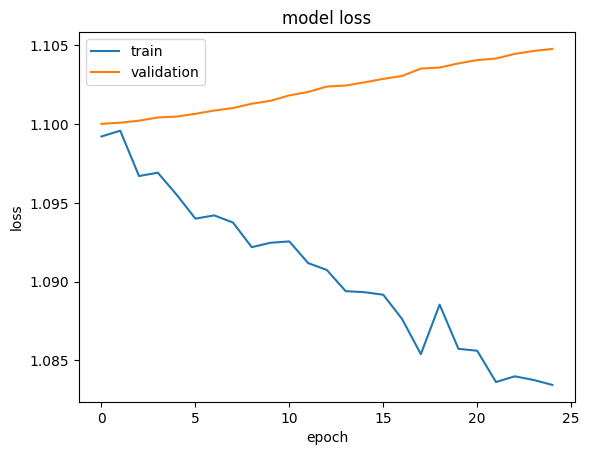

In [56]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Validate Test Dataset

In [57]:
path = 'best_model_multiclass.pt'
model.load_state_dict(torch.load(path))

# Move inputs to the same device
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.31      0.34      0.33       370
           1       0.32      0.30      0.31       369
           2       0.28      0.27      0.27       369

    accuracy                           0.30      1108
   macro avg       0.30      0.30      0.30      1108
weighted avg       0.30      0.30      0.30      1108



Matriz de confusión:
 [[127 112 131]
 [130 110 129]
 [147 122 100]]


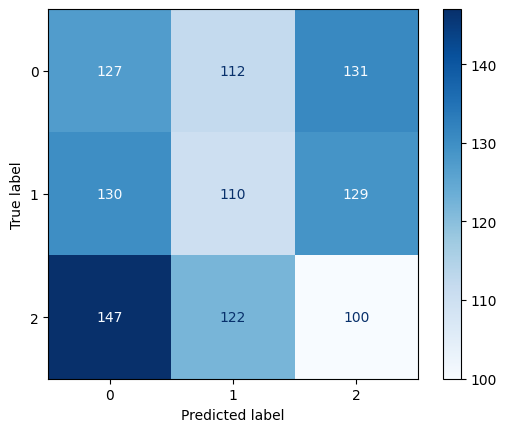

In [26]:
# Cargar el modelo
model_path = "best_model_multiclass.pt"  # Ruta al modelo guardado
model.load_state_dict(torch.load(model_path))  # O usa `torch.load()` y carga manualmente el estado si usaste state_dict
model.eval()  # Cambiar a modo de evaluación

# Preparar el conjunto de prueba
test_loader = ...  # DataLoader para el conjunto de prueba
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Variables para almacenar predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

# Evaluar en el conjunto de prueba
with torch.no_grad():
    for batch in test_dataloader:
        # Desempaquetar el batch
        inputs, masks, labels = batch
        
        # Enviar a GPU si está disponible
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        # Obtener predicciones del modelo
        outputs = model(inputs, masks)
        _, preds = torch.max(outputs, 1)  # Obtener la clase predicha
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:\n", cm)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()